# Stock Market Prediction using Machine Learning
Predicting next-day GOOGL price upward movements using technical indicators and market sentiment data.

## PART 1 - OPERATION EXTRACT (Create Your Dataset) - 25 MARKS

#### CORE REQUIREMENTS COVERED:
 - Use an existing public CSV (Kaggle or official portals): Yahoo Finance + FRED
 - Perform data processing: merge(), pct_change(), ffill(), dropna()
 - Produce at least 2 visualizations: Visualization 1 (Close + MA5 Trend Chart), Visualization 2 (VIX Distribution for Up/Down Days)

#### BONUS REQUIREMENTS COVERED (+10 Points):
 - Build dataset from 2 or more APIs/web sources: YF + FRED (2 sources)
 - Engineer at least 2 features: Created 5 features

Part 1: Preparing GOOGL stock (YF) + FRED VIX data (2 years)
Samples: 497
Data saved as: GOOGL_2y_Dataset.csv



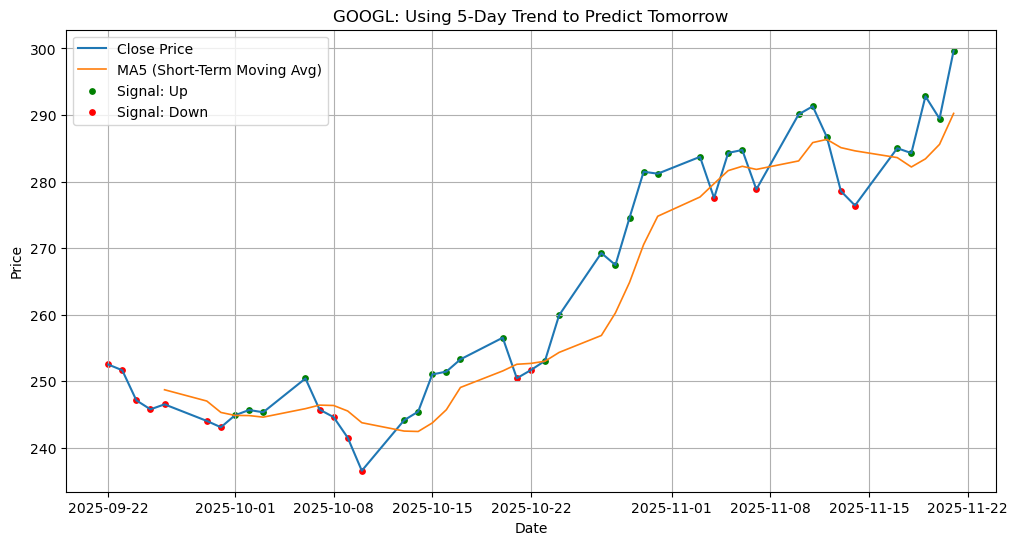

The Short_Trend_Signal feature (Close > MA5) helps predict next-day price movement
Green points (price > MA5) often precede continued upward movement



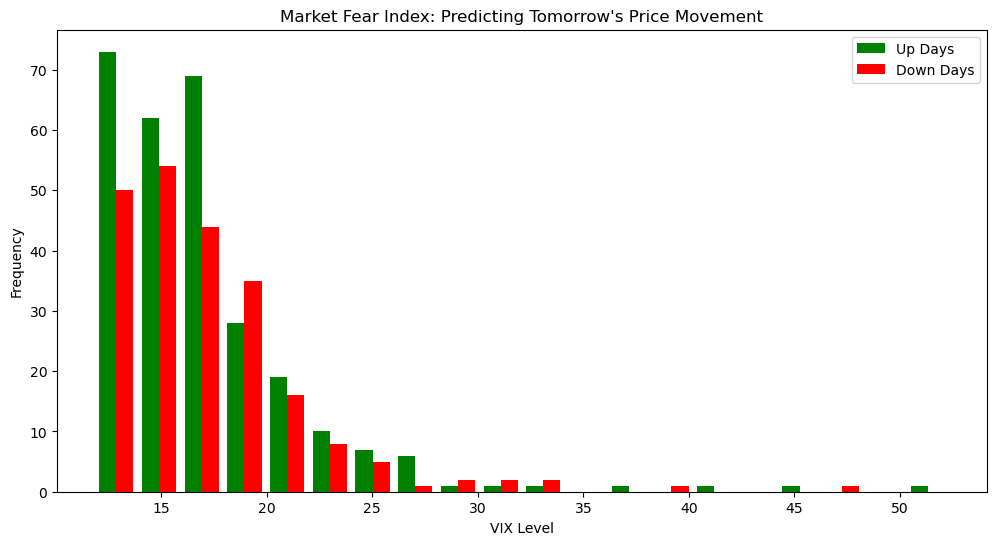

Shows the distribution of key features (VIX and Returns) for up vs down days
Helps identify patterns: lower VIX → higher up probability
Validates that our engineered features have predictive value for the ML model


In [613]:
# Please ensure the following installation commands have been executed before running:
# !pip install yfinance fredapi pandas numpy xgboost scikit-learn

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import yfinance as yf # Yahoo Finance API - Stock Data
from fredapi import Fred # Federal Reserve API - Economic Data
import warnings

# Model Training and Evaluation Libraries
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

# Visualization
import matplotlib.pyplot as plt

# Configuration and API Setup
TICKER = 'GOOGL'                                  # Target stock for prediction
FILE_NAME = f'{TICKER}_2y_Dataset.csv'            # Define filename for saving processed data later
FRED_API_KEY = 'afd5db0013b58a4b0cca92b8d9ddb247' # Free FRED API key from St. Louis Federal Reserve Bank (https://fred.stlouisfed.org)
fred = Fred(api_key=FRED_API_KEY)                 # Create FRED client to fetch data

def get_fred_vix(start_date, end_date):
    """
    Fetches VIX (market volatility/fear index) data from FRED API
    Returns daily VIX values for the specified date range
    """
    
    vix_data = fred.get_series('VIXCLS',                    # VIXCLS = VIX closing prices
                              observation_start=start_date,  # From this date
                              observation_end=end_date       # To this date
                              ).to_frame(name='VIX')         # Convert Series to DataFrame with column name 'VIX'
        
    vix_data = vix_data.ffill() # Forward fill: use previous day's value for missing days (weekends/holidays)
    return vix_data

print("Part 1: Preparing GOOGL stock (YF) + FRED VIX data (2 years)")

# Set dates
end_date = '2025-11-22'
start_date = '2023-11-22'

# 1. Stock Data (YFinance)
# Download historical stock price data from Yahoo Finance
stock = yf.download(
    TICKER,           # The stock we want (defined earlier as 'GOOGL')
    start=start_date, # Beginning date of data
    end=end_date,     # Ending date of data
    progress=False,   # Don't show download progress bar
    auto_adjust=True  # Adjust for stock splits and dividends automatically
)

# print(stock.columns) # Uncomment to see column structure before flattening
# Flatten column names if multi-level
if stock.columns.nlevels > 1:
    stock.columns = stock.columns.get_level_values(0)

# 2. VIX Data (FRED)
vix_data = get_fred_vix(start_date, end_date) # Fetch VIX fear index data from FRED API

# 3. Merge and Core Features
# Merge stock and VIX data into one DataFrame using date index as the key
df = stock.merge(vix_data,           # Combine stock data with VIX data
                 left_index=True,     # Use stock's date index for joining (stock is left table / main table)
                 right_index=True,)    # Use VIX's date index for joining (VIX is right table)

# Calculate daily returns: (today's price - yesterday's price) / yesterday's price
df['Returns'] = df['Close'].pct_change()
# Example: Day1=$100, Day2=$102 → Returns = (102-100)/100 = 0.02 = 2%

# Calculate volume change rate: how much trading volume changed from yesterday
df['Volume_Change'] = df['Volume'].pct_change()
# Example: Yesterday=1M shares, Today=1.5M → Change = 0.5 = 50% increase

# Calculate intraday volatility: (highest price / lowest price) - 1
df['High_Low_Ratio'] = (df['High'] / df['Low']) - 1
# Example: High=$155, Low=$150 → 155/150 - 1 = 0.033 = 3.3% spread
# Low volatility = Market consensus → Trend continuation
# High volatility = Market disagreement → Possible reversal

# 4. Feature Engineering
df['VIX_Change_5d'] = df['VIX'].pct_change(periods=5)
# Calculate how much VIX changed compared to 5 days ago (5→20 = 33% increase)
# Purpose: Detect if fear is increasing/decreasing to predict tomorrow's direction
# VIX rising rapidly → Panic intensifying → Tomorrow likely down
# VIX falling rapidly → Fear subsiding → Tomorrow likely rebound

df['Short_Trend_Signal'] = (df['Close'] > df['Close'].rolling(window=5).mean()).astype(int)
# Create signal: 1 if price above 5-day moving average (uptrend), 0 if below (downtrend)


# 5. Output and Final Dataset
df['Tomorrow_Up'] = (df['Close'].shift(-1) > df['Close']).astype(int)
# Create target variable: 1 if tomorrow's price > today's price, 0 otherwise

features = ['Returns', 'Volume_Change', 'High_Low_Ratio', 
            'VIX', 'VIX_Change_5d', 'Short_Trend_Signal']
# Define which features to use for machine learning model


ml_data = df[features + ['Tomorrow_Up']].dropna() # Create final dataset: keep only features+target, remove rows with any NaN values
ml_data.to_csv(FILE_NAME)                         # Save the cleaned dataset to CSV file (GOOGL_2y_Dataset.csv)
print(f"Samples: {len(ml_data)}")
print(f"Data saved as: {FILE_NAME}")
print()

# 6. Visualizations

# Visualization 1: Close + MA5 Trend Chart
# Purpose: Visualize how Short_Trend_Signal works

df_vis = df[['Close']].tail(45).copy()                           # Get last 45 days for visualization
df_vis['MA5'] = df_vis['Close'].rolling(5).mean()                # Calculate 5-day moving average
df_vis['Signal'] = (df_vis['Close'] > df_vis['MA5']).astype(int) # 1 if above MA5, 0 if below

plt.figure(figsize=(12,6)) # Create a figure with width=12 inches, height=6 inches

# Close price
plt.plot(df_vis.index, df_vis['Close'], label='Close Price', linewidth=1.5)
# Plot a line chart: x-axis=dates, y-axis=closing prices, with label for legend


# MA5
plt.plot(df_vis.index, df_vis['MA5'], label='MA5 (Short-Term Moving Avg)', linewidth=1.2)
# Plot the 5-day moving average line (orange color by default)


# Trend signal points: Green (Close > MA5), Red (Close ≤ MA5)
# Plot green dots when price is above MA5
plt.scatter(
    df_vis.index[df_vis['Signal'] == 1],        # X: dates where Signal=1
    df_vis['Close'][df_vis['Signal'] == 1],     # Y: prices where Signal=1  
    color='green',                              # Dot color
    label='Signal: Up',                         # Legend text
    s=15                                        # Dot size (15 pixels)
)

# Plot red dots when price is below MA5
plt.scatter(
    df_vis.index[df_vis['Signal'] == 0],        # X: dates where Signal=0
    df_vis['Close'][df_vis['Signal'] == 0],     # Y: prices where Signal=0
    color='red', label='Signal: Down', s=15     # Red dots, size 15
)

plt.title(f'{TICKER}: Using 5-Day Trend to Predict Tomorrow')  # Chart title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Price') # Y-axis label  
plt.legend()        # Show legend (The legend box in the top left)
plt.grid(True)      # Add grid lines in the background
plt.show()          # Display the plot

print("The Short_Trend_Signal feature (Close > MA5) helps predict next-day price movement")
print("Green points (price > MA5) often precede continued upward movement")
print()


# Visualization 2: VIX Distribution for Up/Down Days

plt.figure(figsize=(12, 6)) # Create a figure with width=12 inches, height=6 inches

# Get VIX data for up and down days
df_up = df[df['Tomorrow_Up'] == 1]['VIX'].dropna()      # VIX values when next day goes up
df_down = df[df['Tomorrow_Up'] == 0]['VIX'].dropna()    # VIX values when next day goes down

# Plot histogram showing VIX distribution for up/down days
plt.hist([df_up, df_down],               # Data: VIX values for up days and down days
         label=['Up Days', 'Down Days'], # Legend labels
         bins=20,                        # Divide VIX range into 20 bins
         color=['green', 'red'])         # Colors for each dataset

plt.title('Market Fear Index: Predicting Tomorrow\'s Price Movement')  # Chart title
plt.xlabel('VIX Level')      # X-axis label
plt.ylabel('Frequency')      # Y-axis label (count of occurrences)
plt.legend()                 # Show legend (The legend box in the top left)
plt.show()                   # Display the plot

print("Shows the distribution of key features (VIX and Returns) for up vs down days")
print("Helps identify patterns: lower VIX → higher up probability")
print("Validates that our engineered features have predictive value for the ML model")

## Feature Engineering Justification

Our 6 features capture different market dimensions:

| Feature | Type | Why It Matters |
|---------|------|----------------|
| Returns | Price Momentum | Trends tend to persist (momentum effect), Stocks that have risen recently are likely to continue rising in the short term.|
| Volume_Change | Market Activity | Volume changes help confirm price movements, Abnormal volume often signals important price action |
| High_Low_Ratio | Volatility | Measures how much the price jumped around during the day. Big jumps = nervous market |
| VIX | Market Fear | The "fear index" - high VIX typically correlates with market declines.  |
| VIX_Change_5d | Sentiment Trend | Tracks whether market fear is increasing or decreasing over 5 days. |
| Short_Trend_Signal | Technical | Price above 5-day MA suggests upward momentum; below suggests downward pressure |

**Key Insight**: Combining multiple signals (price + volume + sentiment) provides more robust predictions than any single indicator.